## Projektarbeit: How to avoid dying from eating poisonous mushrooms

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import math
import tqdm
from mpl_toolkits.mplot3d import Axes3D
import shap
from shap import Explainer
from shap.plots import beeswarm
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# fetch dataset
m_shroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
x = m_shroom.data.features
y = m_shroom.data.targets

mushroom = pd.concat([x, y], axis=1)

# metadata
print(m_shroom.metadata)

# variable information
print(m_shroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [3]:
x.head ()

cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   
3         n          n           e  ...                        s   
4         b          k           t  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 22 columns]

In [4]:
y.head ()

poisonous
0         p
1         e
2         e
3         p
4         e

In [5]:
# Split data for testing and training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=None)

print('Train set shape: {}'.format(x_train.shape))
print('Test set shape: {}'.format(x_test.shape))

Train set shape: (5443, 22)
Test set shape: (2681, 22)


In [6]:
# Rename the column to "target"
y_train.rename(columns={"poisonous": "target"}, inplace=True)
y_test.rename(columns={"poisonous": "target"}, inplace=True)

# Encoding of the target
y_train['target'] = y_train['target'].map({'p': 1, 'e': 0})
y_test['target'] = y_test['target'].map({'p': 1, 'e': 0})

In [7]:
# Label-Encoding of x-values
label_encoders = {}
for column in x_train.columns:
    encoder = LabelEncoder()
    x_train[column] = encoder.fit_transform(x_train[column])
    x_test[column] = encoder.transform(x_test[column])

In [11]:
# One-Hot-Encoding of x-values
# encoder = OneHotEncoder(drop="first")
#encoder.fit(x_train)
#x_encoded = encoder.transform(x_train)
#x_train = pd.DataFrame(x_encoded.todense(),columns=encoder.get_feature_names_out())

#encoder.fit(x_test)
#x_encoded2 = encoder.transform(x_test)
#x_test = pd.DataFrame(x_encoded2.todense(),columns=encoder.get_feature_names_out())

In [8]:
# Normalizing x-values
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert the numpy arrays to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

x_train = x_train_scaled
x_test = x_test_scaled

In [9]:
# Imputing missing values with pandas dataframe
kni = KNNImputer ()
x_train = kni.fit_transform(x_train)
x_test = kni.transform(x_test)

x_train = pd.DataFrame(x_train,columns=m_shroom.data.features.columns)
x_test = pd.DataFrame(x_test,columns=m_shroom.data.features.columns)

In [10]:
# dropping "veil-type"
to_drop = ["veil-type"]
x_train.drop(to_drop, axis=1, inplace=True)
x_test.drop(to_drop, axis=1, inplace=True)

## Machine Learning Models

### KNeirestNeighbors

In [11]:
# Building a Model: KNeirestneighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [16]:
# Finding the best k
# x_train = x_train.values if isinstance(x_train, pd.DataFrame) else x_train
# x_test = x_test.values if isinstance(x_test, pd.DataFrame) else x_test
# y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
# y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

# Ensure y_train is a 1D array
#if y_train.ndim > 1:
#   y_train = y_train.squeeze()

# Finding the best k
#scores = []
#for i in range(1, 50):
#    knn = KNeighborsClassifier(n_neighbors=i)
#    knn.fit(x_train, y_train)
#    scores.append(knn.score(x_test, y_test))

#plt.title("Accuracy in dependence of k")
#plt.plot(range(1, 50), scores, label="Accuracy of kNN")
#plt.xlabel("k")
#plt.ylabel("Accuracy")
#plt.legend()
#plt.show()

In [17]:
# SHAP value for feature importance
print(type(x_train))
print(x_train.shape)

print(type(knn))
print(hasattr(knn, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_knn = shap.KernelExplainer(knn.predict, background_samples)
shap_values_knn = explainer_knn.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_knn).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for kNN")
shap.summary_plot(shap_values_knn, x_train, plot_type="bar")
plt.show()

<class 'pandas.core.frame.DataFrame'>
(5443, 21)
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 21)


KeyboardInterrupt: 

In [15]:
# calculate accuracy, precision and recall for knn
predict_knn = knn.predict(x_test)

cm = confusion_matrix(predict_knn, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for knn: {}".format(accuracy_score(predict_knn, y_test)))
print("precision for knn: {}".format(tp/(tp + fp)))
print("recall for knn: {}".format(tp/(tp + fn)))

accuracy for knn: 1.0
precision for knn: 1.0
recall for knn: 1.0


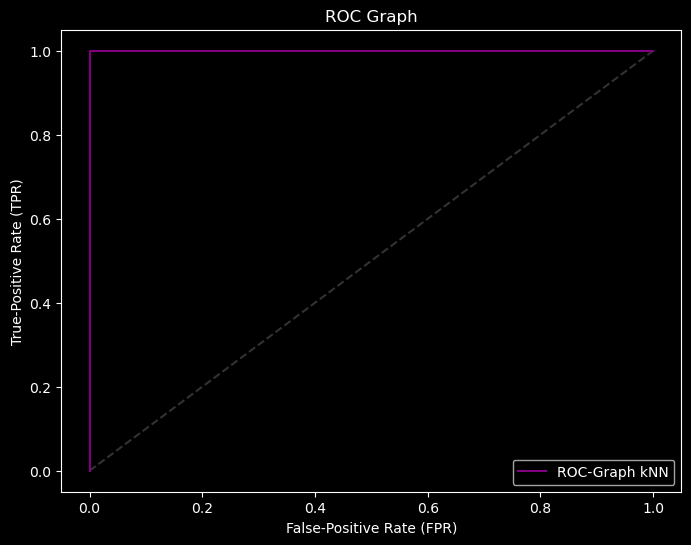

In [13]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph kNN",c="purple")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Decision Tree

In [16]:
# Building a Model: Decision Tree
dtc = DecisionTreeClassifier(splitter="best", min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=9, criterion="entropy", class_weight = "balanced")
dtc.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=2, min_samples_split=8)

In [ ]:
# optimizing hyperparameters
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': [None, 'sqrt', 'log2'],
    "class_weight": ["balanced", None]
}

decision_tree = DecisionTreeClassifier()
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_dist, scoring='accuracy', n_iter=100, cv=3,verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train_scaled, y_train.values.ravel())

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 9, 'criterion': 'entropy', 'class_weight': 'balanced'}


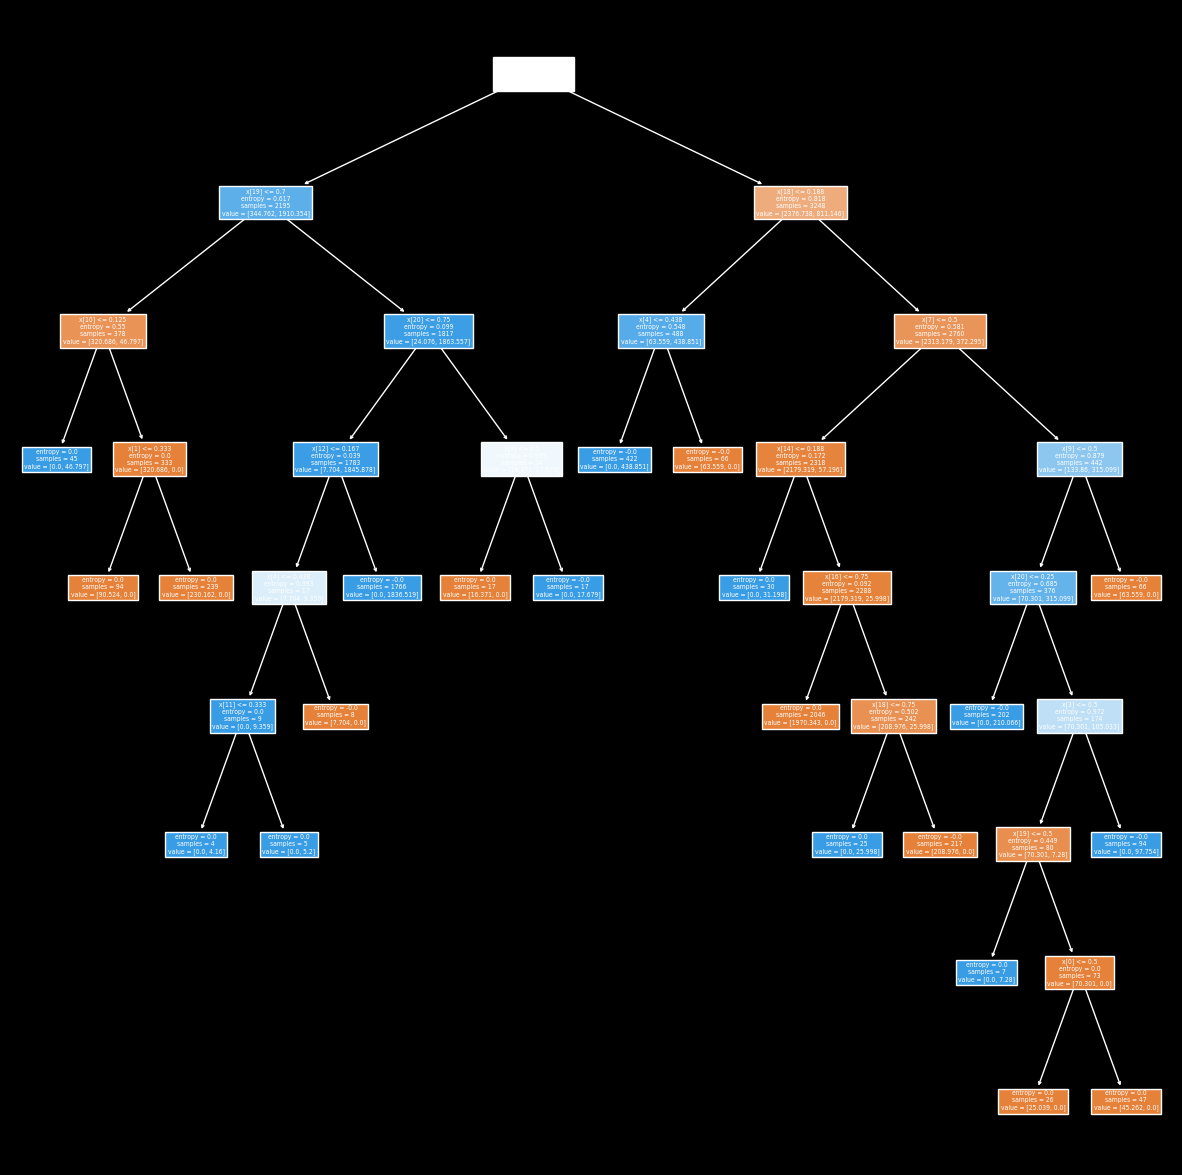

In [17]:
fig = plt.figure(figsize=(15,15))
baum = tree.plot_tree(dtc, filled=True)

In [18]:
# calculate feature importance with SHAP
explainer_short_dtc= shap.Explainer(dtc)
sv_dtc= explainer_short_dtc(x_train)

shap.plots.beeswarm(sv_dtc[:, :, 1])

In [ ]:
print(type(x_train))
print(x_train.shape)

print(type(dtc))
print(hasattr(dtc, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_dtc = shap.KernelExplainer(dtc.predict, background_samples)
shap_values_dtc = explainer_dtc.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_dtc).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for decision tree")
shap.summary_plot(shap_values_dtc, x_train, plot_type="bar")
plt.show()

<class 'pandas.core.frame.DataFrame'>
(5443, 21)
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 21)


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_

Background samples shape: (1, 21)
SHAP values shape: (5443, 21)


In [19]:
# calculate accuracy, precision and recall for dtc
predict_dtc = dtc.predict(x_test)

cm = confusion_matrix(predict_dtc, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for Decision Tree: {}".format(accuracy_score(predict_dtc, y_test)))
print("precision for Decision Tree: {}".format(tp/(tp + fp)))
print("recall for Decision Tree: {}".format(tp/(tp + fn)))

accuracy for Decision Tree: 1.0
precision for Decision Tree: 1.0
recall for Decision Tree: 1.0


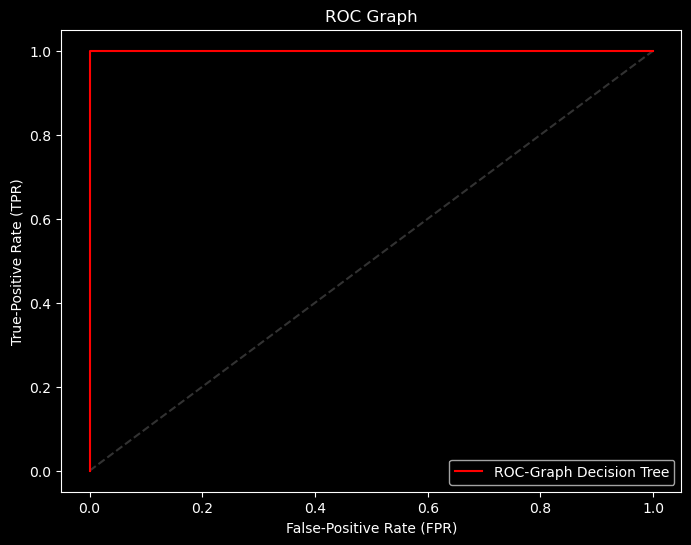

In [20]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, dtc.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Decision Tree",c="red")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Logistic Regression

In [21]:
# Building a model: Logistic Regression
logreg = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=200, C=1526.418)
logreg.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1526.418, max_iter=200)

In [ ]:
# Optimizing Hyperparameters with Random Search
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': np.logspace(-4, 4, 50),
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
    'max_iter': [100, 200, 300, 400, 500],
    'l1_ratio': np.linspace(0, 1, 20)  # Only used if penalty is 'elasticnet'
}

random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_dist,scoring='accuracy', n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train_scaled, y_train.values.ravel())

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': 0.0, 'C': 719.6856730011514}


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(logreg))
print(hasattr(logreg, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_logreg = shap.KernelExplainer(logreg.predict, background_samples)
shap_values_logreg = explainer_logreg.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_logreg).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for logistic regression")
shap.summary_plot(shap_values_logreg, x_train, plot_type="bar")
plt.show()

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.linear_model._logistic.LogisticRegression'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


In [22]:
# calculate accuracy, precision and recall for logistic regression
predict_logreg = logreg.predict(x_test)

cm = confusion_matrix(predict_logreg, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for Logistic Regression: {}".format(accuracy_score(predict_logreg, y_test)))
print("precision for Logistic Regression: {}".format(tp/(tp + fp)))
print("recall for Logistic Regression: {}".format(tp/(tp + fn)))

accuracy for Logistic Regression: 0.9600895188362552
precision for Logistic Regression: 0.962278675904542
recall for Logistic Regression: 0.9556574923547401


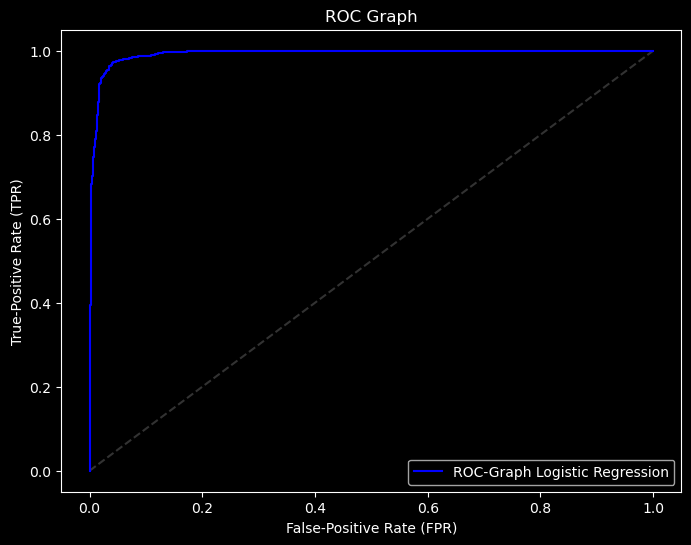

In [ ]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, logreg.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Logistic Regression",c="blue")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Support Vector Machine Classifier

In [23]:
# Building a model: Support Vector Machine
svm = SVC(probability=True, kernel='rbf', gamma=0.0048, degree=5, coef0=3, class_weight=None, C=10000.0)
svm.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10000.0, coef0=3, degree=5, gamma=0.0048, probability=True)

In [ ]:
# Optimizing hyperparameters

param_dist = {
    'C': np.logspace(-4, 4, 20),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': np.arange(1, 6),
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 4, 20)),
    'coef0': np.arange(0, 5),
    'class_weight': ['balanced', None],
    'probability': [True]
}

svm = SVC()

random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist,scoring='accuracy', n_iter=100, cv=3,verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train_scaled, y_train.values.ravel())

print(random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'probability': True, 'kernel': 'rbf', 'gamma': 0.004832930238571752, 'degree': 5, 'coef0': 3, 'class_weight': None, 'C': 10000.0}


<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.svm._classes.SVC'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


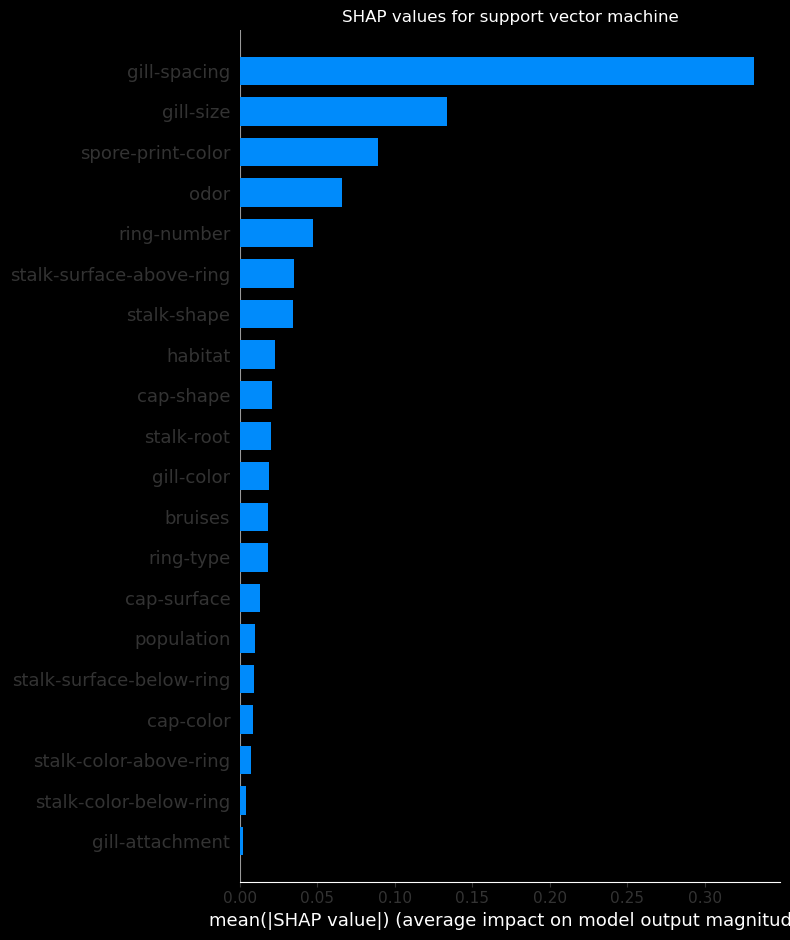

In [ ]:
# SHAP
print(type(x_train))
print(x_train.shape)

print(type(svm))
print(hasattr(svm, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_svm = shap.KernelExplainer(svm.predict, background_samples)
shap_values_svm = explainer_svm.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_svm).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for support vector machine")
shap.summary_plot(shap_values_svm, x_train, plot_type="bar")
plt.show()

In [24]:
# calculate accuracy, precision and recall for support vector machine
predict_svm = svm.predict(x_test)

cm = confusion_matrix(predict_svm, y_test)
_, fp, fn, tp = cm.ravel()
print("accuracy of support vector machine: {}".format(accuracy_score(predict_svm, y_test)))
print("precision of support vectir machine: {}".format(tp/(tp + fp)))
print("recall of support vector machine: {}".format(tp/(tp + fn)))

accuracy of support vector machine: 1.0
precision of support vectir machine: 1.0
recall of support vector machine: 1.0


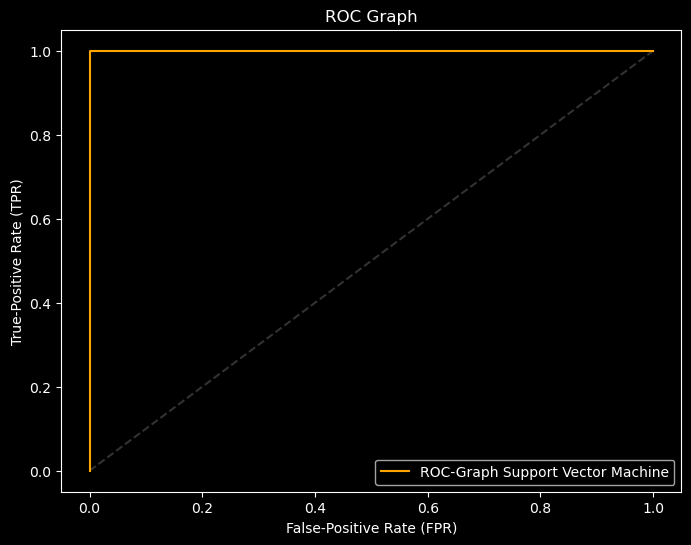

In [ ]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, svm.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Support Vector Machine",c="orange")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Random Forest

In [26]:
# Building a Model: Random Forest
random = RandomForestClassifier (n_estimators=100, min_samples_split=8, min_samples_leaf=8, max_features='sqrt', max_depth=10, criterion='gini', class_weight='balanced_subsample', bootstrap=False)
random.fit(x_train, y_train)

/var/folders/_s/1t0lm39d5b1bl47vd_q5jfth0000gn/T/ipykernel_6932/2779676426.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random.fit(x_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=8, min_samples_split=8)

In [ ]:
# optimizing hyperparameters
param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_forest = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist,scoring='accuracy', n_iter=100, cv=3,verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train_scaled, y_train.values.ravel ())

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': False}


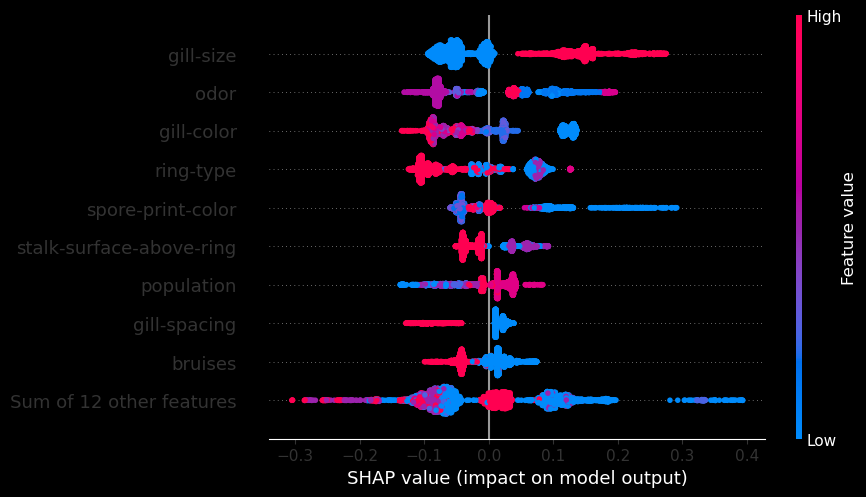

In [27]:
# calculate feature importance with SHAP
explainer_short_random = shap.Explainer(random)
sv_random = explainer_short_random(x_train)

shap.plots.beeswarm(sv_random[:, :, 1])

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


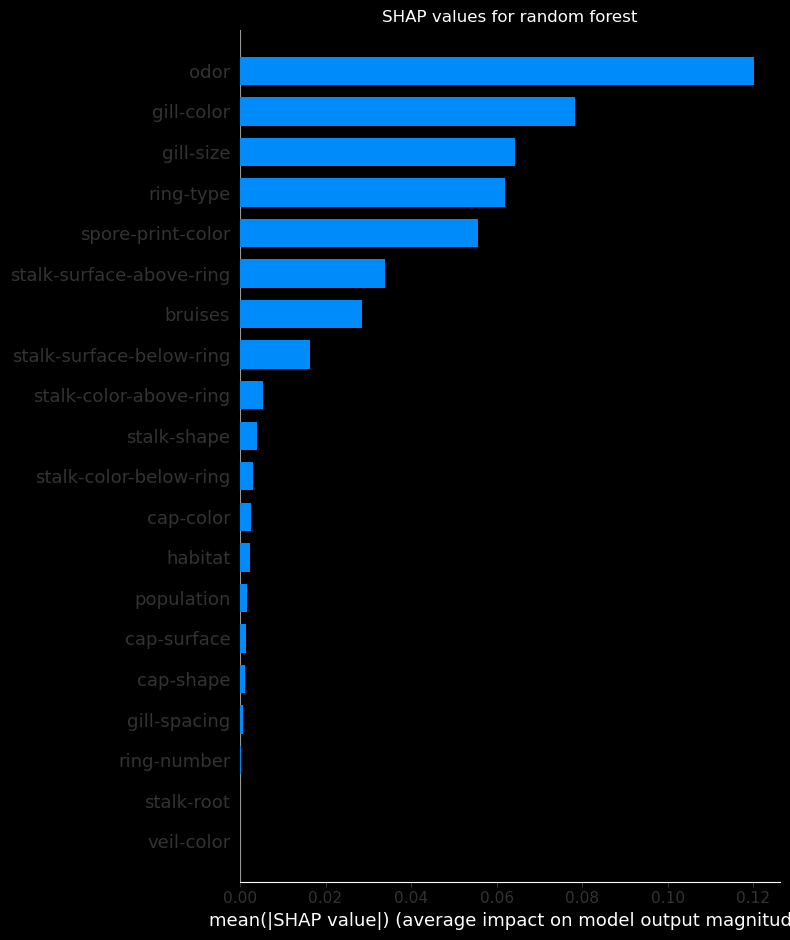

In [ ]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(random))
print(hasattr(random, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_random = shap.KernelExplainer(random.predict, background_samples)
shap_values_random = explainer_random.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_random).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for random forest")
shap.summary_plot(shap_values_random, x_train, plot_type="bar")
plt.show()

In [29]:
# calculate accuracy, precision and recall for random forest
predict_random = random.predict(x_test)

cm = confusion_matrix(predict_random, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of random forest: {}".format(accuracy_score(predict_random, y_test)))
print("precision of random forest: {}".format(tp/(tp + fp)))
print("recall of random forest: {}".format(tp/(tp + fn)))

accuracy of random forest: 1.0
precision of random forest: 1.0
recall of random forest: 1.0


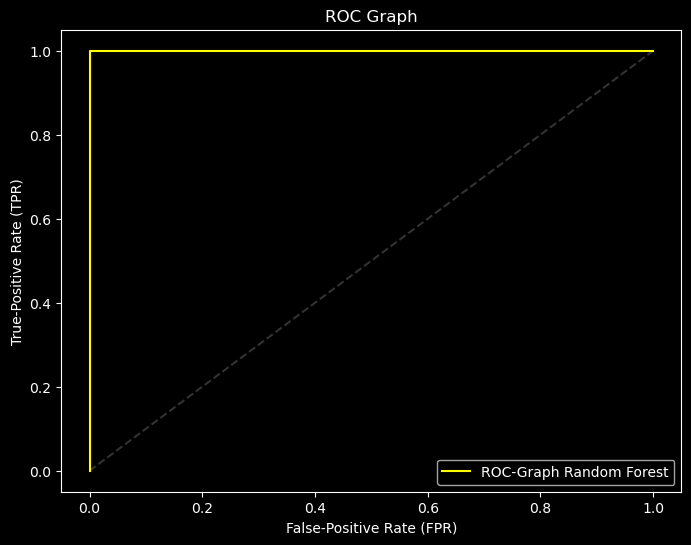

In [30]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, random.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Random Forest",c="yellow")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### XG Boosting 

In [31]:
# Build a Model: XGBoost
bst = XGBClassifier(subsample=1.0, reg_lambda=0.1, reg_alpha=0.5, n_estimators=100, min_child_weight=3, max_depth=8, learning_rate=0.05, gamma=0.1, colsample_bytree=0.7)
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Optimizing Hyperparameters with Random Search
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(estimator=bst, param_distributions=param_dist, scoring='accuracy', n_iter=100, cv=3, verbose=1, n_jobs=-1)
random_search.fit(x_train, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}


<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'xgboost.sklearn.XGBClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(100, 22)
Background samples shape: (100, 22)
SHAP values shape: (5443, 22)


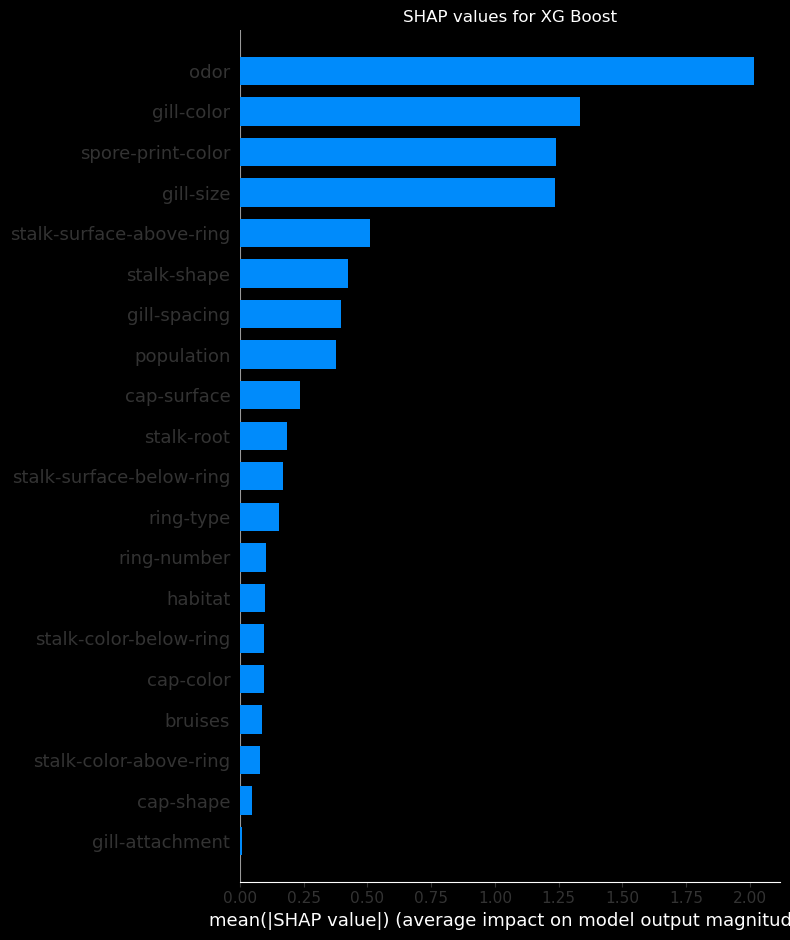

In [ ]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(bst))
print(hasattr(bst, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 100)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_bst = shap.TreeExplainer(bst)
shap_values_bst = explainer_bst.shap_values(x_train)

#explainer_bst = shap.KernelExplainer(bst.predict, background_samples)
#shap_values_bst = explainer_bst.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_bst).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for XG Boost")
shap.summary_plot(shap_values_bst, x_train, plot_type="bar")
plt.show()

In [32]:
# calculate accuracy, precision and recall for XG Boost
predict_bst= bst.predict(x_test)

cm = confusion_matrix(predict_bst, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of XG Boost: {}".format(accuracy_score(predict_bst, y_test)))
print("precision of XG Boost: {}".format(tp/(tp + fp)))
print("recall of XG Boost: {}".format(tp/(tp + fn)))

accuracy of XG Boost: 1.0
precision of XG Boost: 1.0
recall of XG Boost: 1.0


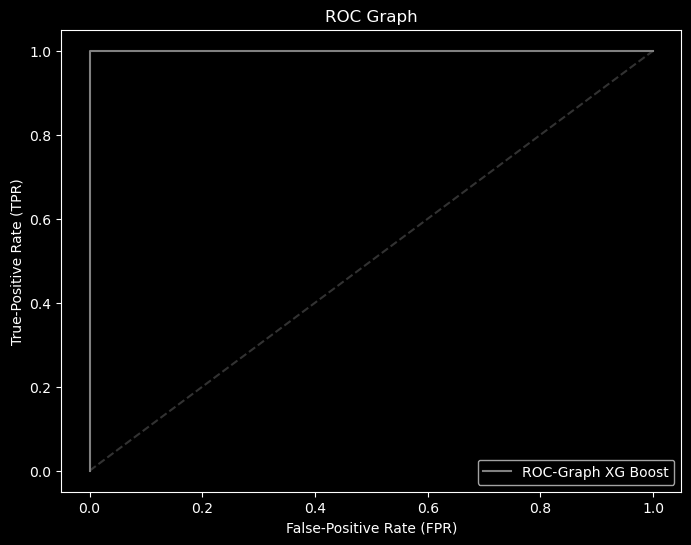

In [33]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, bst.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph XG Boost",c="grey")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Bagging-Ensemble

In [40]:
# Building a Model: Bagging-Ensemble
ensemble = VotingClassifier([("knn",KNeighborsClassifier(n_neighbors=5)),("logreg",LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=1526.418)),("random",RandomForestClassifier(n_estimators=100, min_samples_split=8, min_samples_leaf=8, max_features='sqrt', max_depth=10, criterion='gini', class_weight='balanced_subsample', bootstrap=False))], voting='soft')
ensemble.fit(x_train,y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('logreg',
                              LogisticRegression(C=1526.418, max_iter=500)),
                             ('random',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced_subsample',
                                                     max_depth=10,
                                                     min_samples_leaf=8,
                                                     min_samples_split=8))],
                 voting='soft')

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.ensemble._voting.VotingClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/an

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


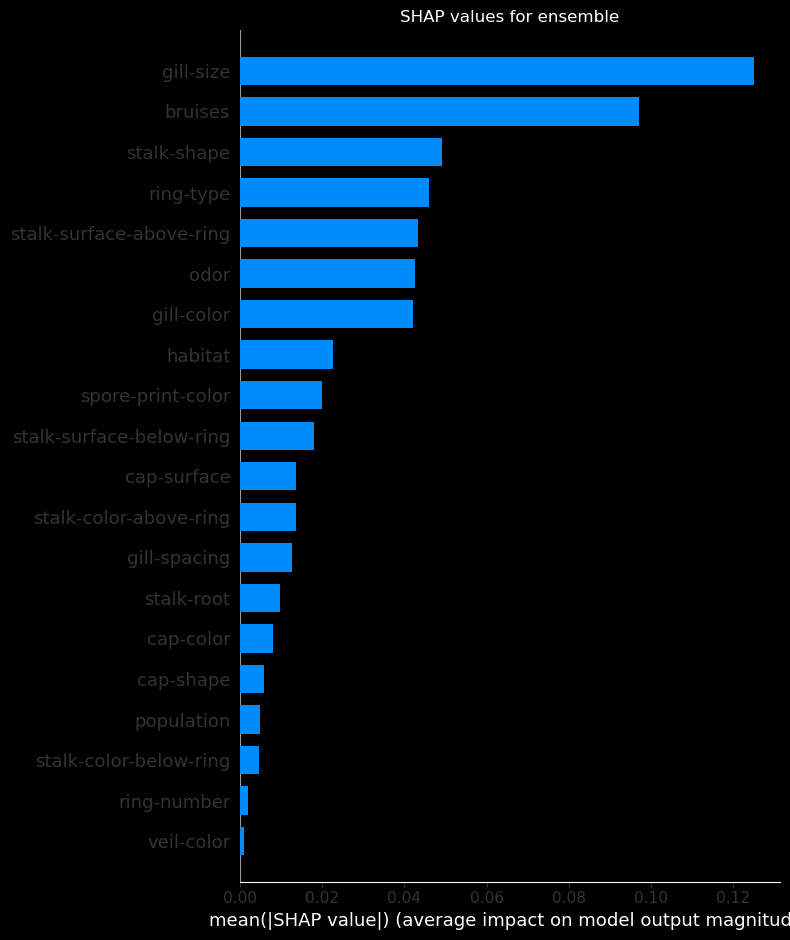

In [ ]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(ensemble))
print(hasattr(ensemble, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_ensemble = shap.KernelExplainer(ensemble.predict, background_samples)
shap_values_ensemble = explainer_ensemble.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_ensemble).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for ensemble")
shap.summary_plot(shap_values_ensemble, x_train, plot_type="bar")
plt.show()

In [41]:
# calculate accuracy, precision and recall for ensemble
predict_ensemble= ensemble.predict(x_test)

cm = confusion_matrix(predict_ensemble, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of ensemble: {}".format(accuracy_score(predict_ensemble, y_test)))
print("precision of ensemble: {}".format(tp/(tp + fp)))
print("recall of ensemble: {}".format(tp/(tp + fn)))

accuracy of ensemble: 1.0
precision of ensemble: 1.0
recall of ensemble: 1.0


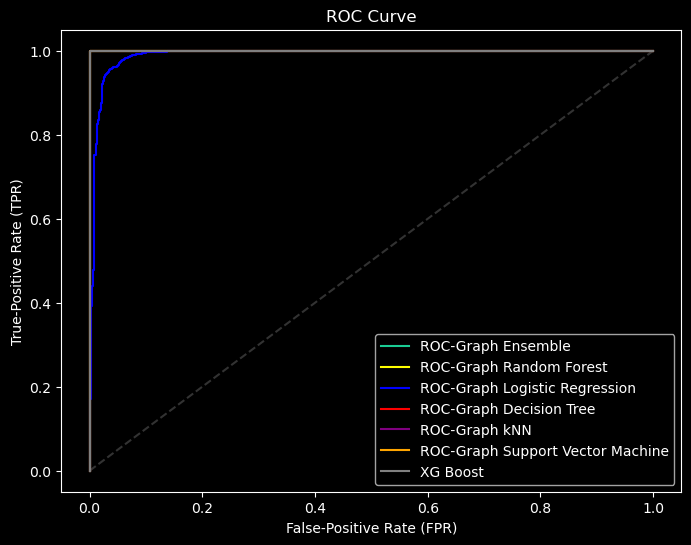

In [42]:
# Graphing all ROC-Curves in one
plt.figure(figsize=(8,6))
plt.title("ROC Curve")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, ensemble.predict_proba(x_test)[:,1:])
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test.values, random.predict_proba(x_test)[:,1:])
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test.values, logreg.predict_proba(x_test)[:,1:])
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test.values, dtc.predict_proba(x_test)[:,1:])
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_test.values, svm.predict_proba(x_test)[:,1:])
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test.values, bst.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Ensemble",c="#1ACC94")
plt.plot(fpr1,tpr1,label="ROC-Graph Random Forest",c="yellow")
plt.plot(fpr2,tpr2,label="ROC-Graph Logistic Regression",c="blue")
plt.plot(fpr3,tpr3,label="ROC-Graph Decision Tree",c="red")
plt.plot(fpr4,tpr4,label="ROC-Graph kNN",c="purple")
plt.plot(fpr5,tpr5,label="ROC-Graph Support Vector Machine",c="orange")
plt.plot(fpr6,tpr6,label="XG Boost",c="grey")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

In [43]:
# calculate AUROC scores
auroc_dtc = roc_auc_score(y_test, predict_dtc)
auroc_logreg = roc_auc_score(y_test, predict_logreg)
auroc_random = roc_auc_score(y_test, predict_random)
auroc_ensemble = roc_auc_score(y_test, predict_ensemble)
auroc_knn = roc_auc_score(y_test, predict_knn)
auroc_svm = roc_auc_score(y_test, predict_svm)
auroc_bst = roc_auc_score(y_test, predict_bst)

print("AUROC-Score for Decision Tree: {}".format(auroc_dtc))
print("AUROC-Score for Logistic Regression: {}".format(auroc_logreg))
print("AUROC-Score for Random Forest: {}".format(auroc_random))
print("AUROC-Score for Ensemble: {}".format(auroc_ensemble))
print("AUROC-Score for kNN: {}".format(auroc_knn))
print("AUROC-Score for Support Vector Machine: {}".format(auroc_svm))
print("AUROC-Score for XG Boost: {}".format(auroc_bst))

AUROC-Score for Decision Tree: 1.0
AUROC-Score for Logistic Regression: 0.9601552569103029
AUROC-Score for Random Forest: 1.0
AUROC-Score for Ensemble: 1.0
AUROC-Score for kNN: 1.0
AUROC-Score for Support Vector Machine: 1.0
AUROC-Score for XG Boost: 1.0
